[*********************100%***********************]  1 of 1 completed
ATVI
Date:1531 Last Day Buy at the price 91.41999816894531


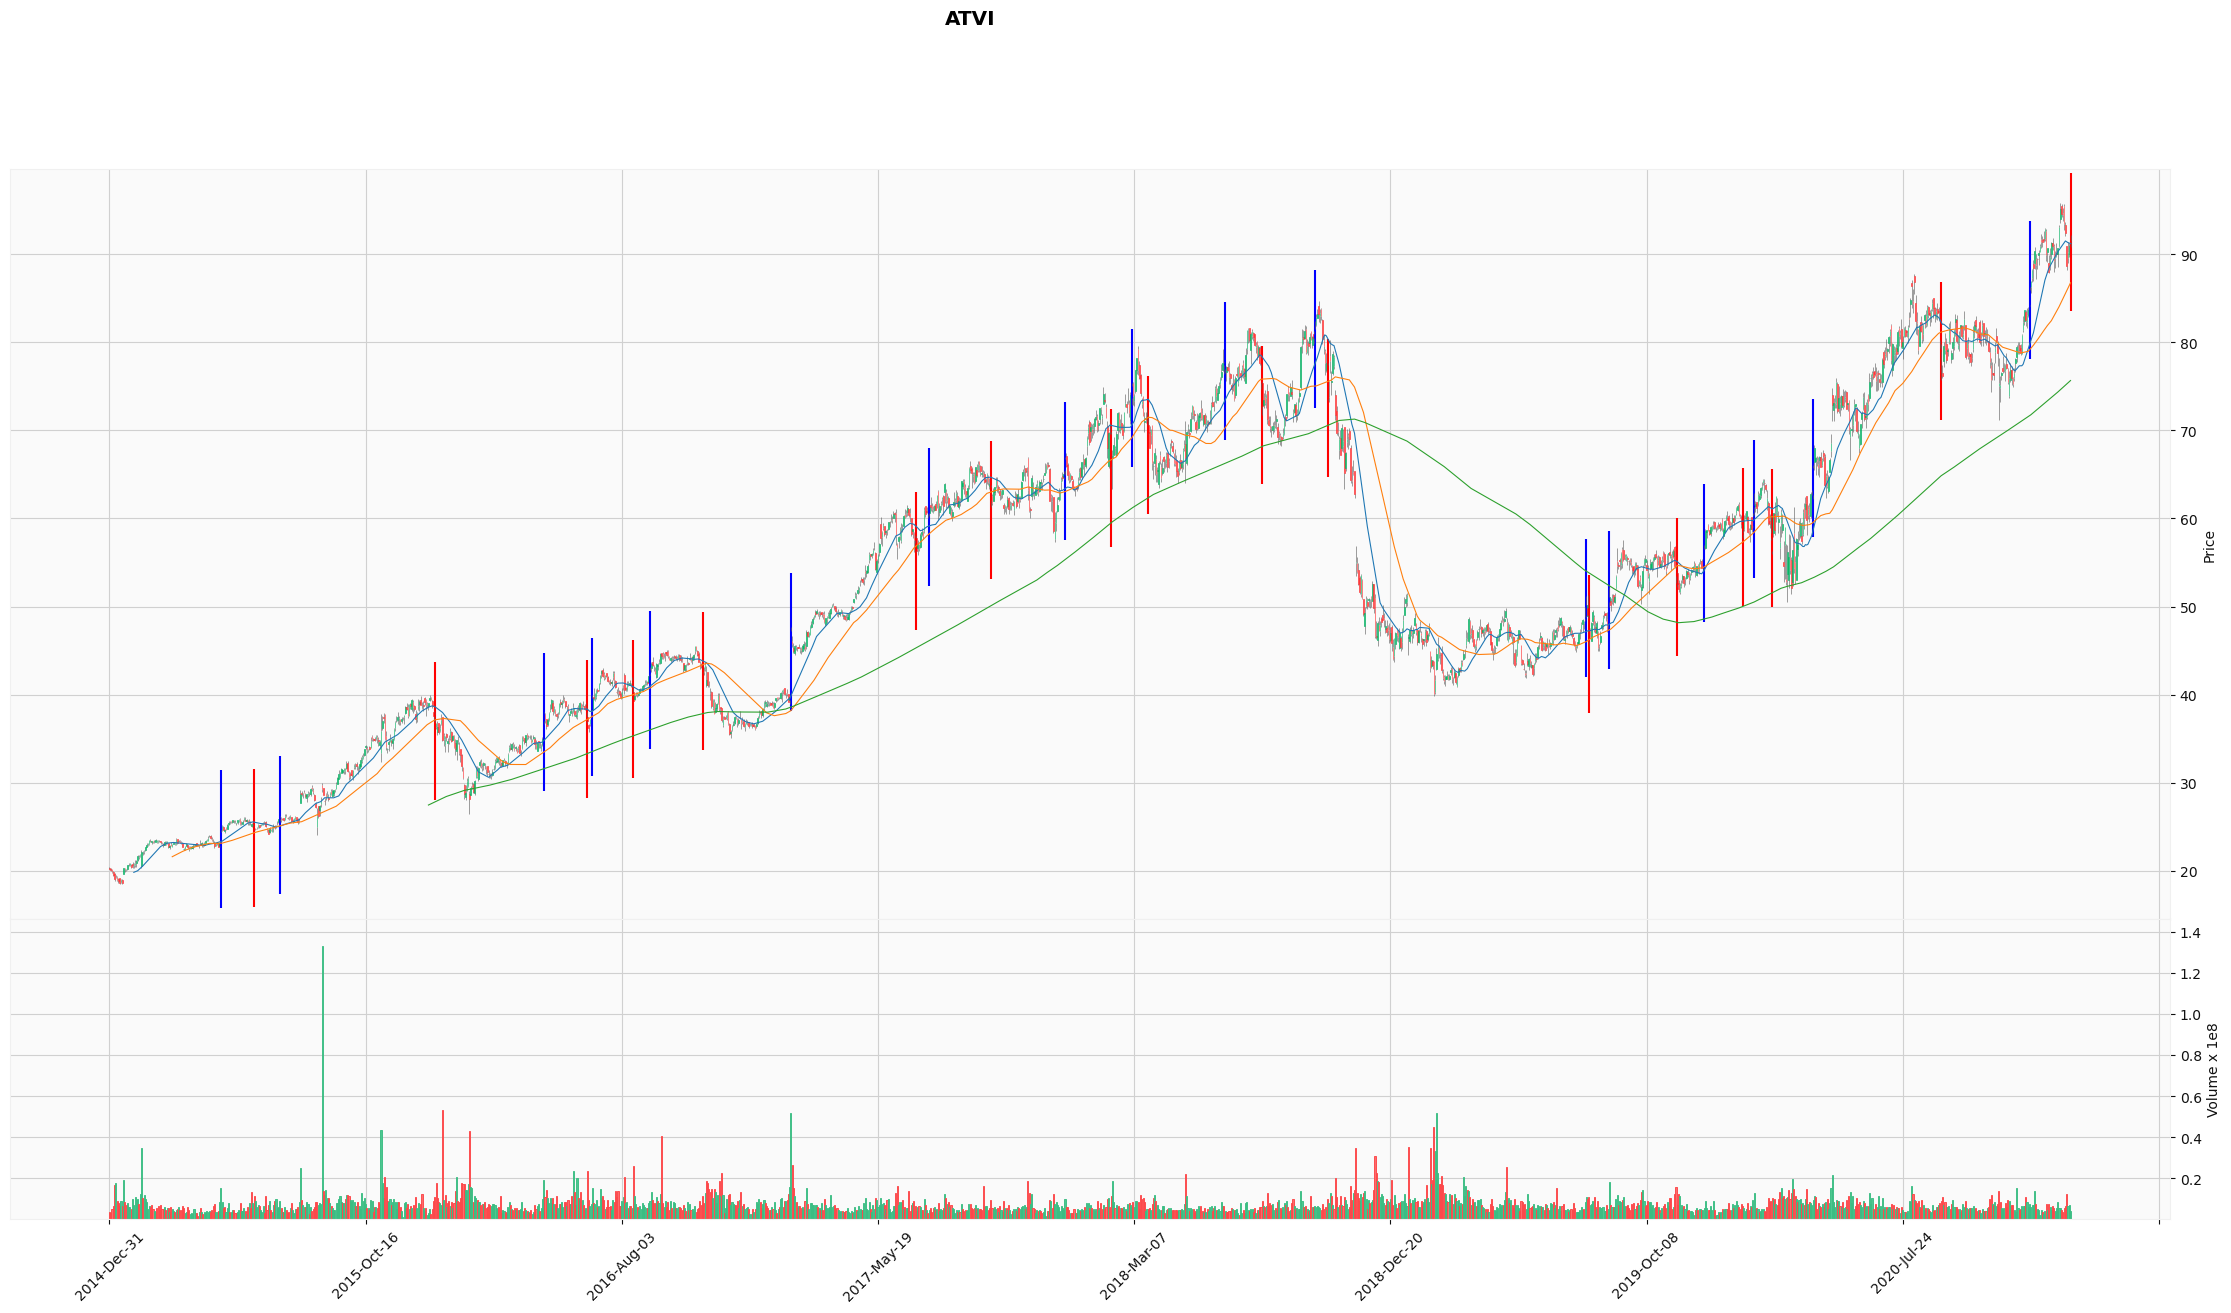

[*********************100%***********************]  1 of 1 completed
AMD


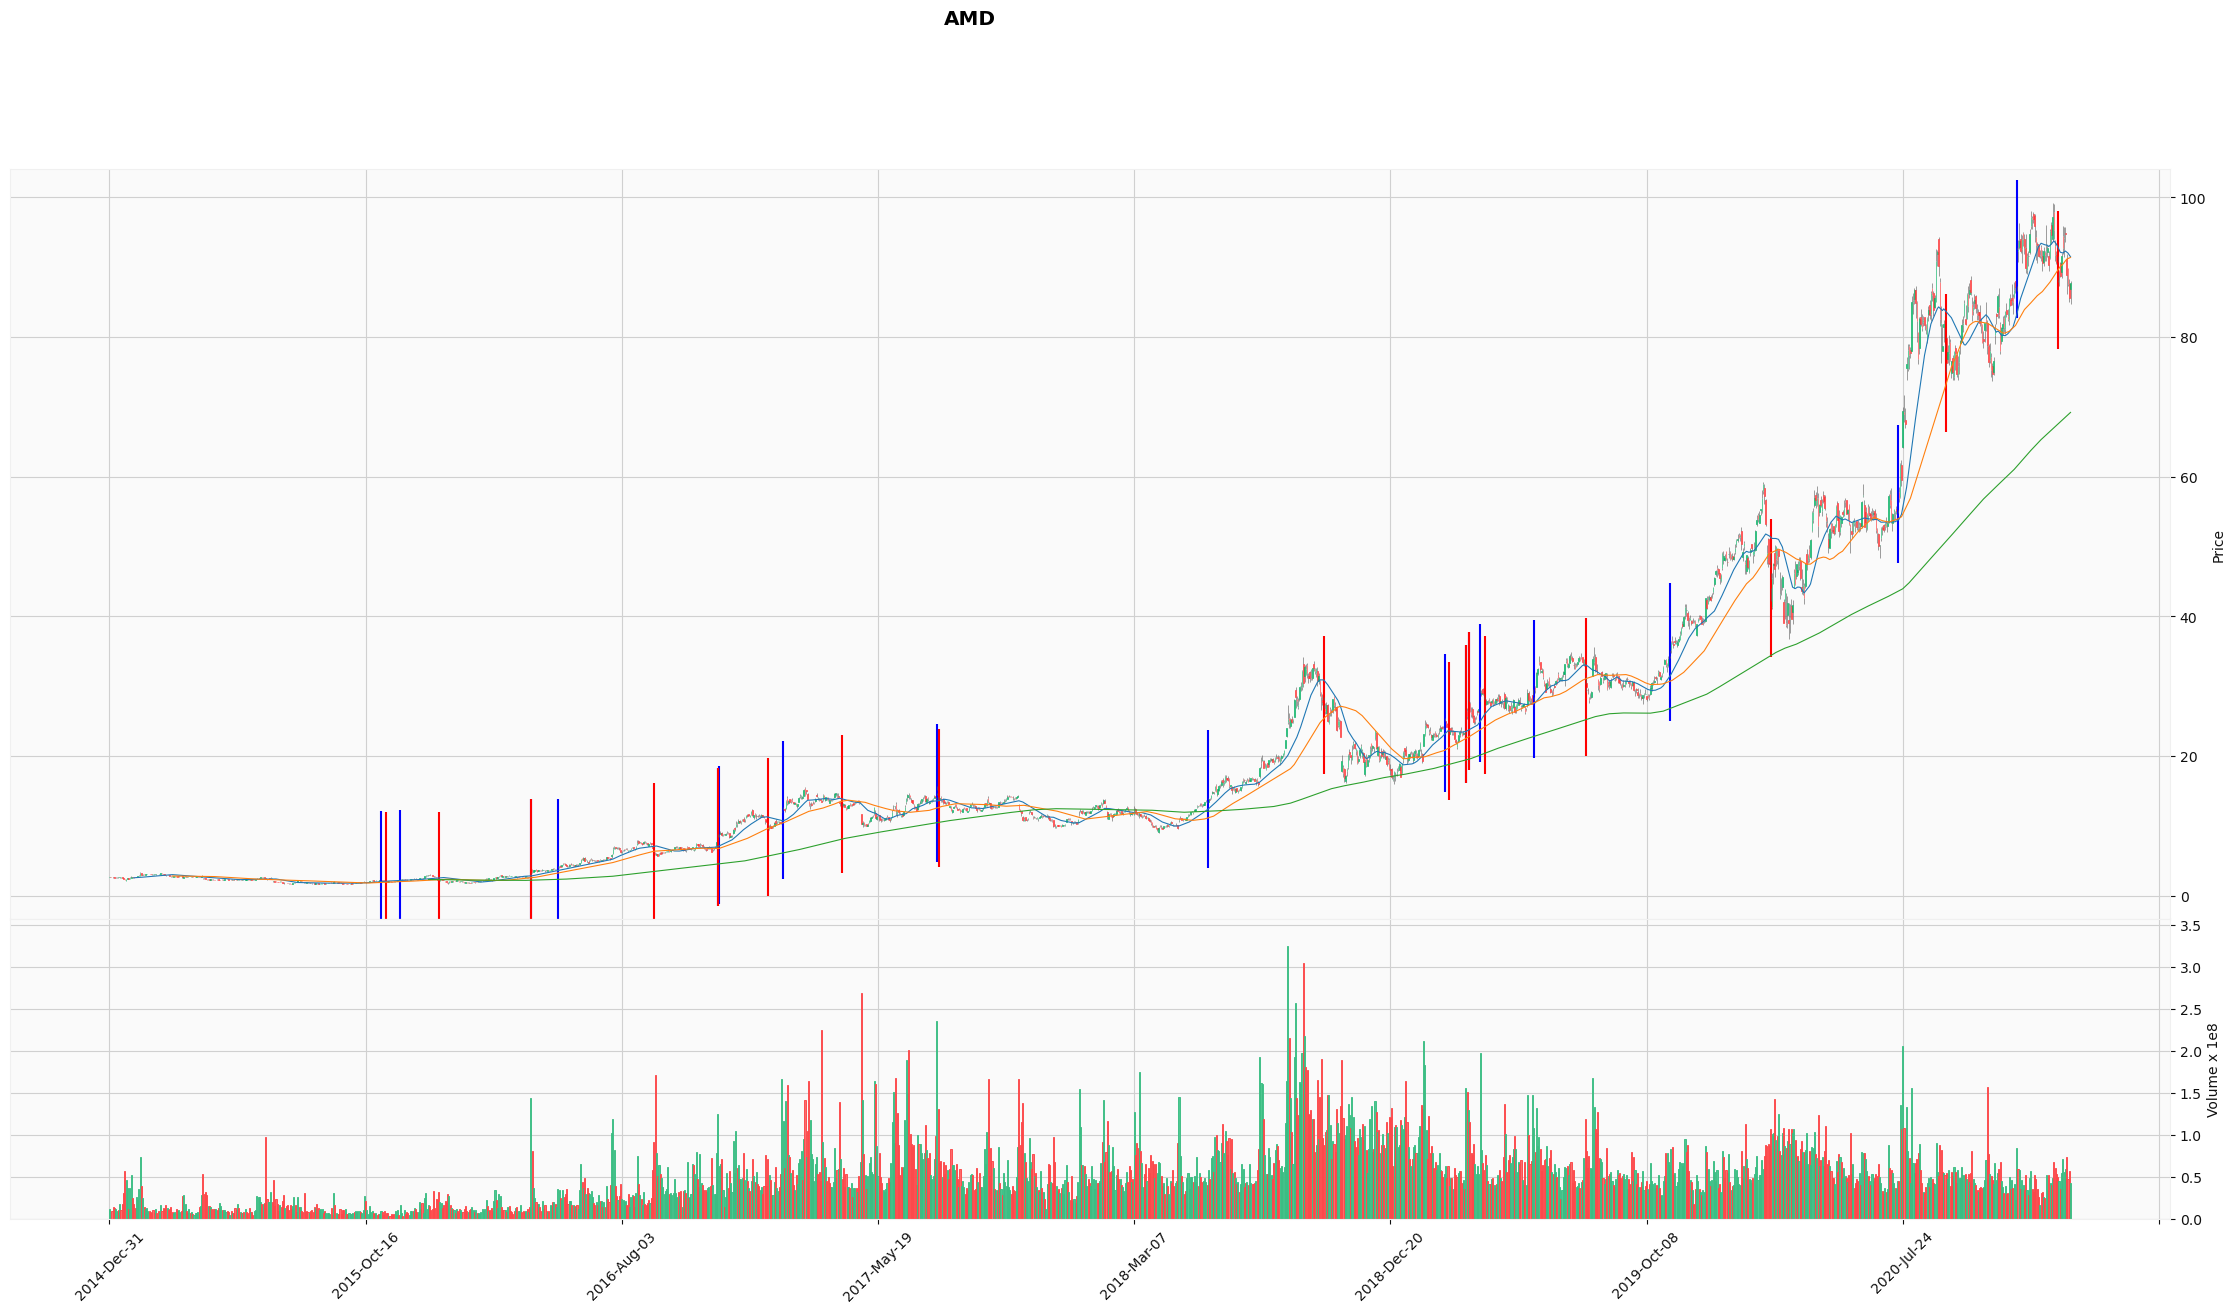

[*********************100%***********************]  1 of 1 completed
ALXN
Date:1531 Last Day Buy at the price 155.6999969482422


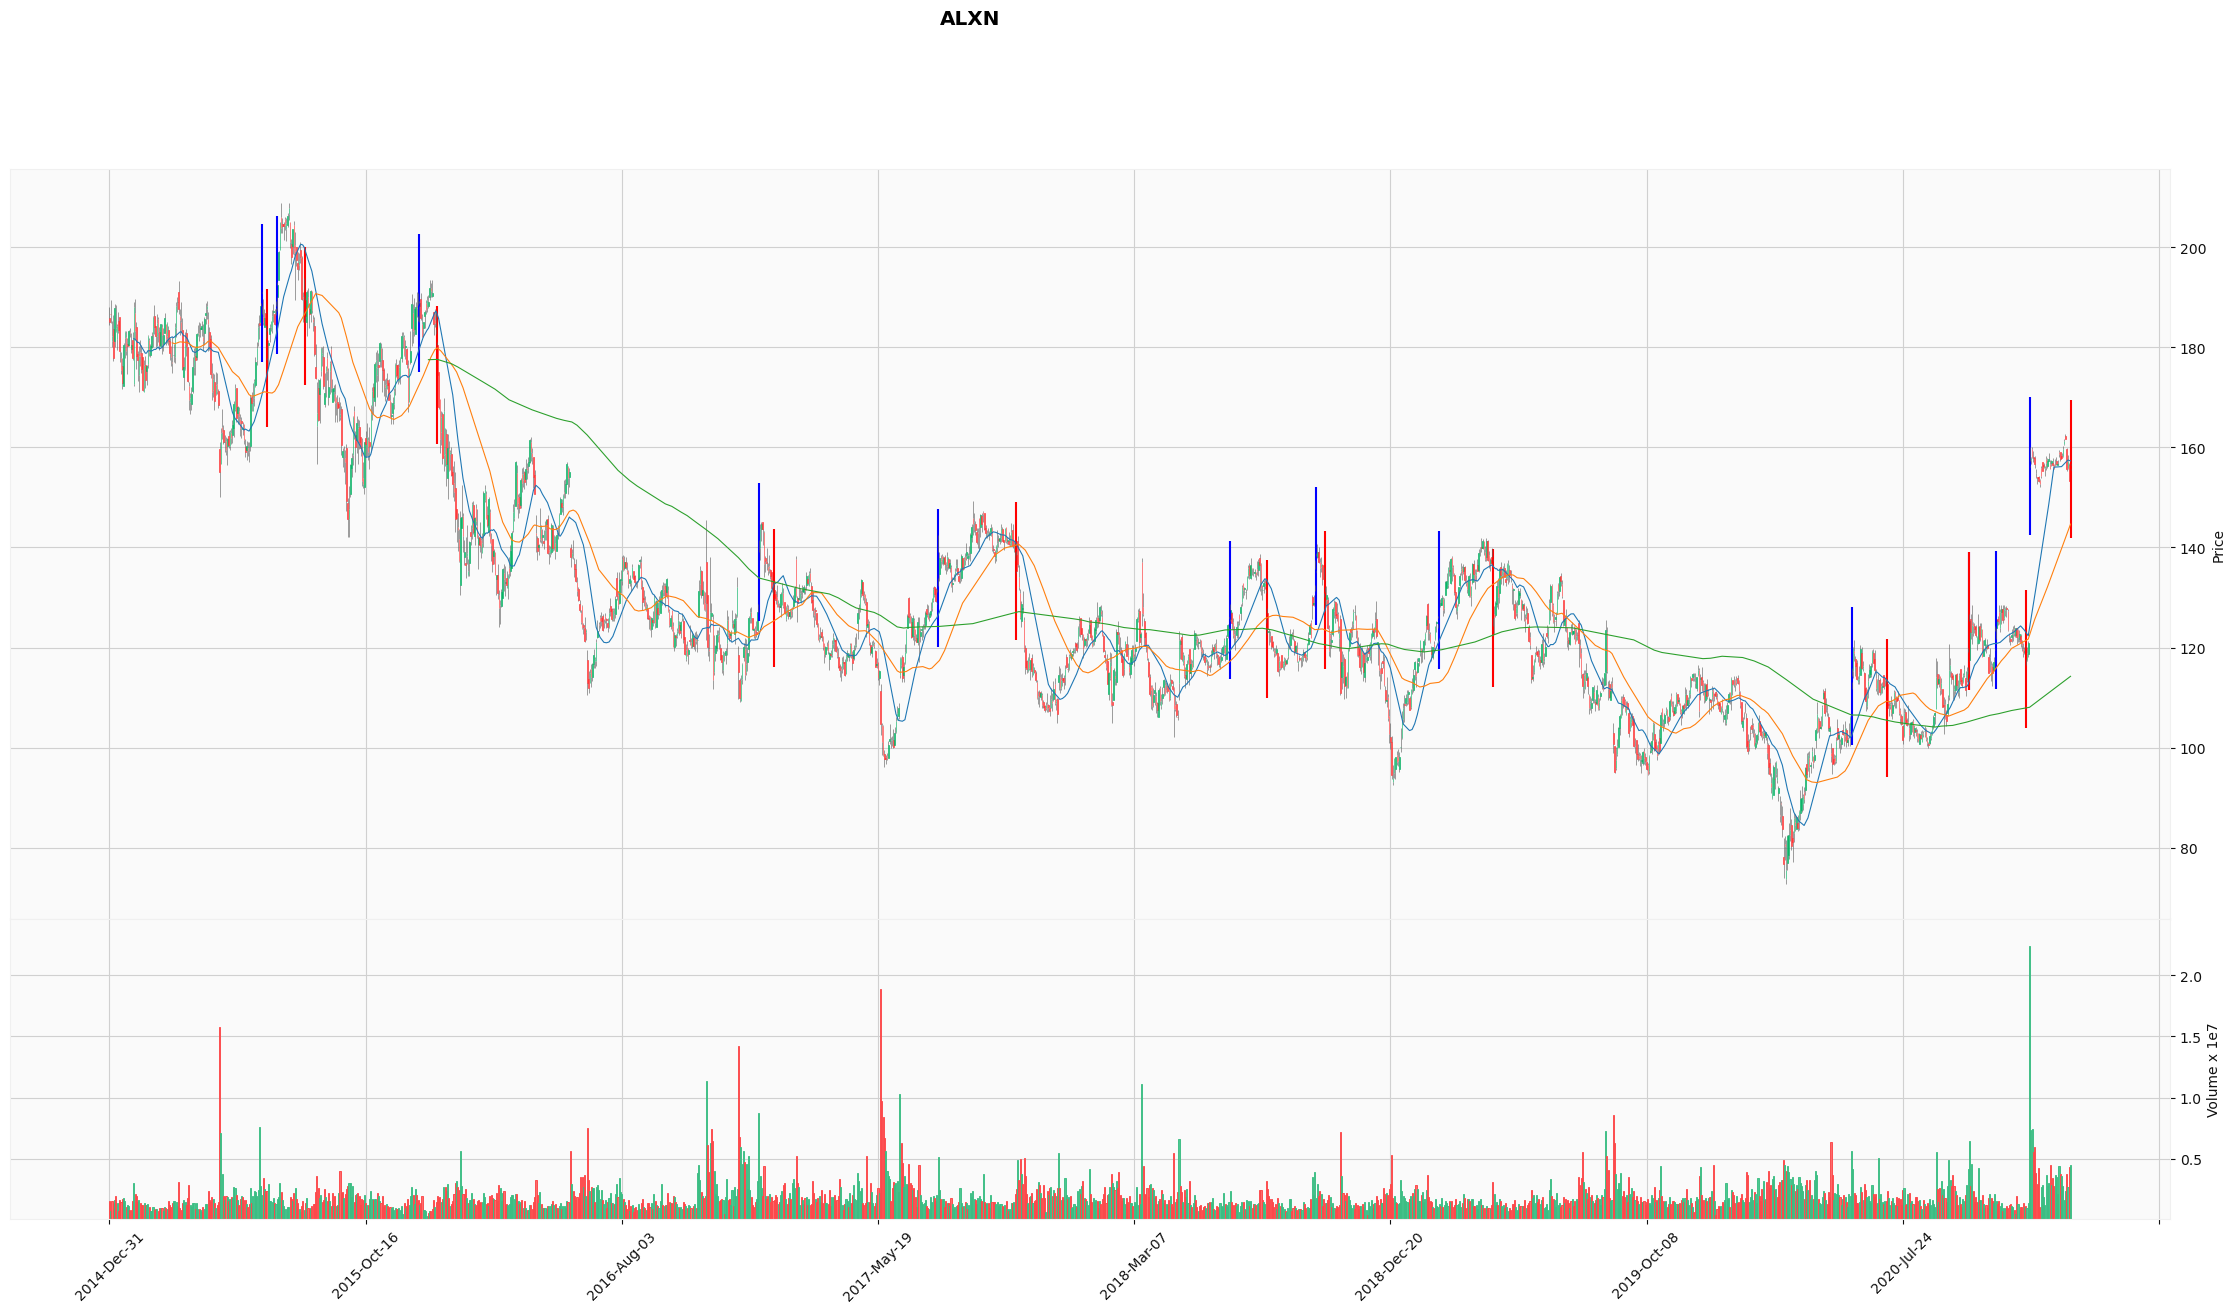

[*********************100%***********************]  1 of 1 completed
ALGN


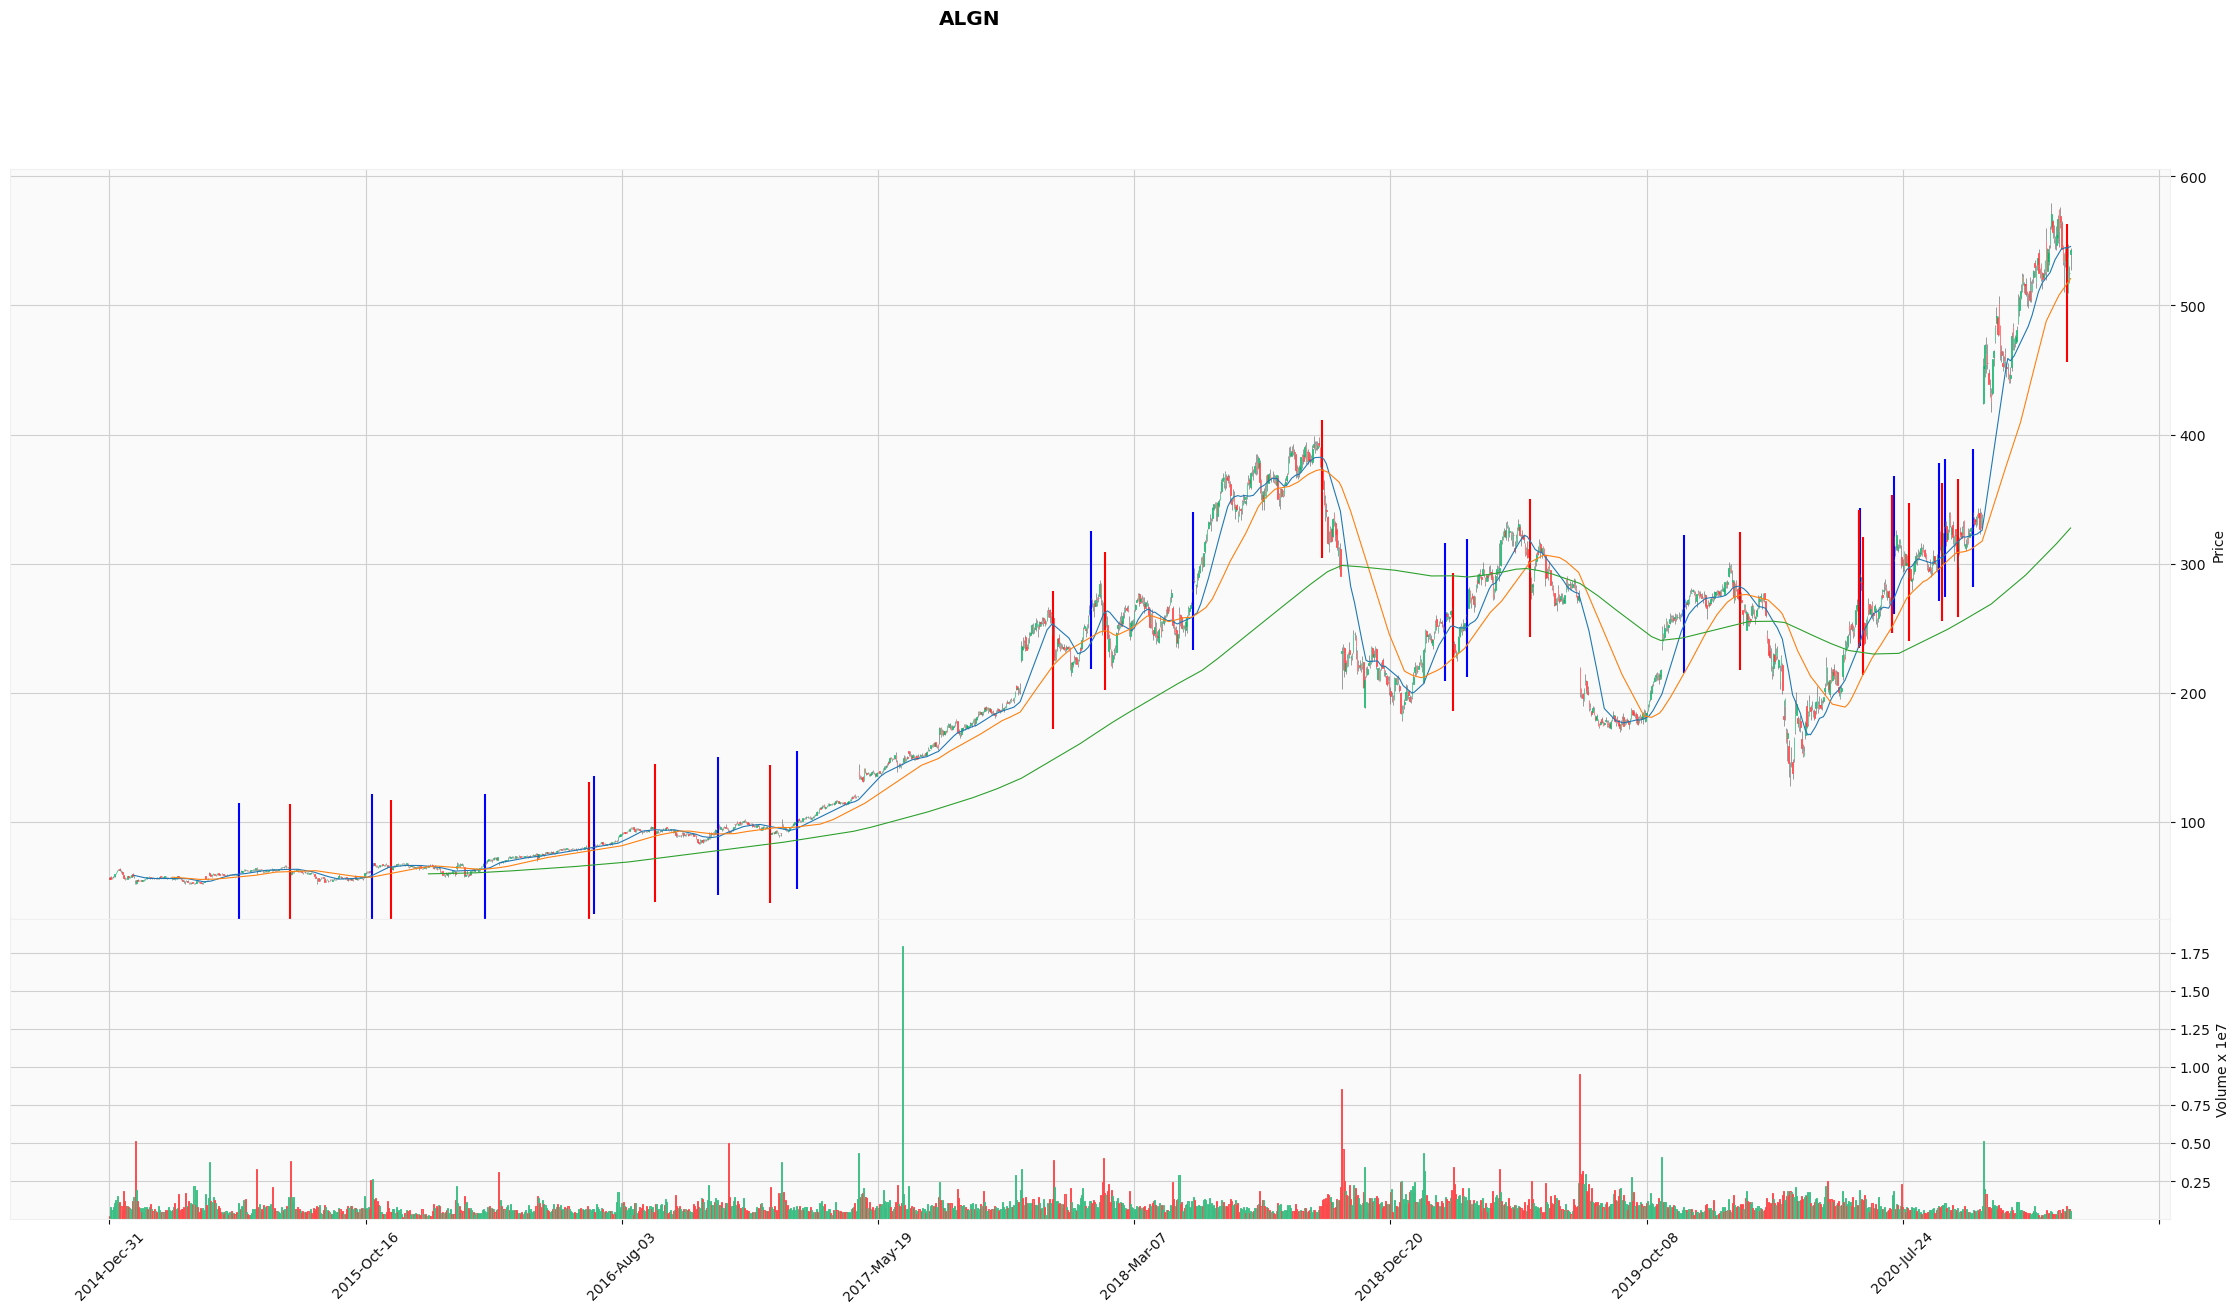

[*********************100%***********************]  1 of 1 completed
GOOGL
Date:1531 Last Day Buy at the price 1893.0699462890625


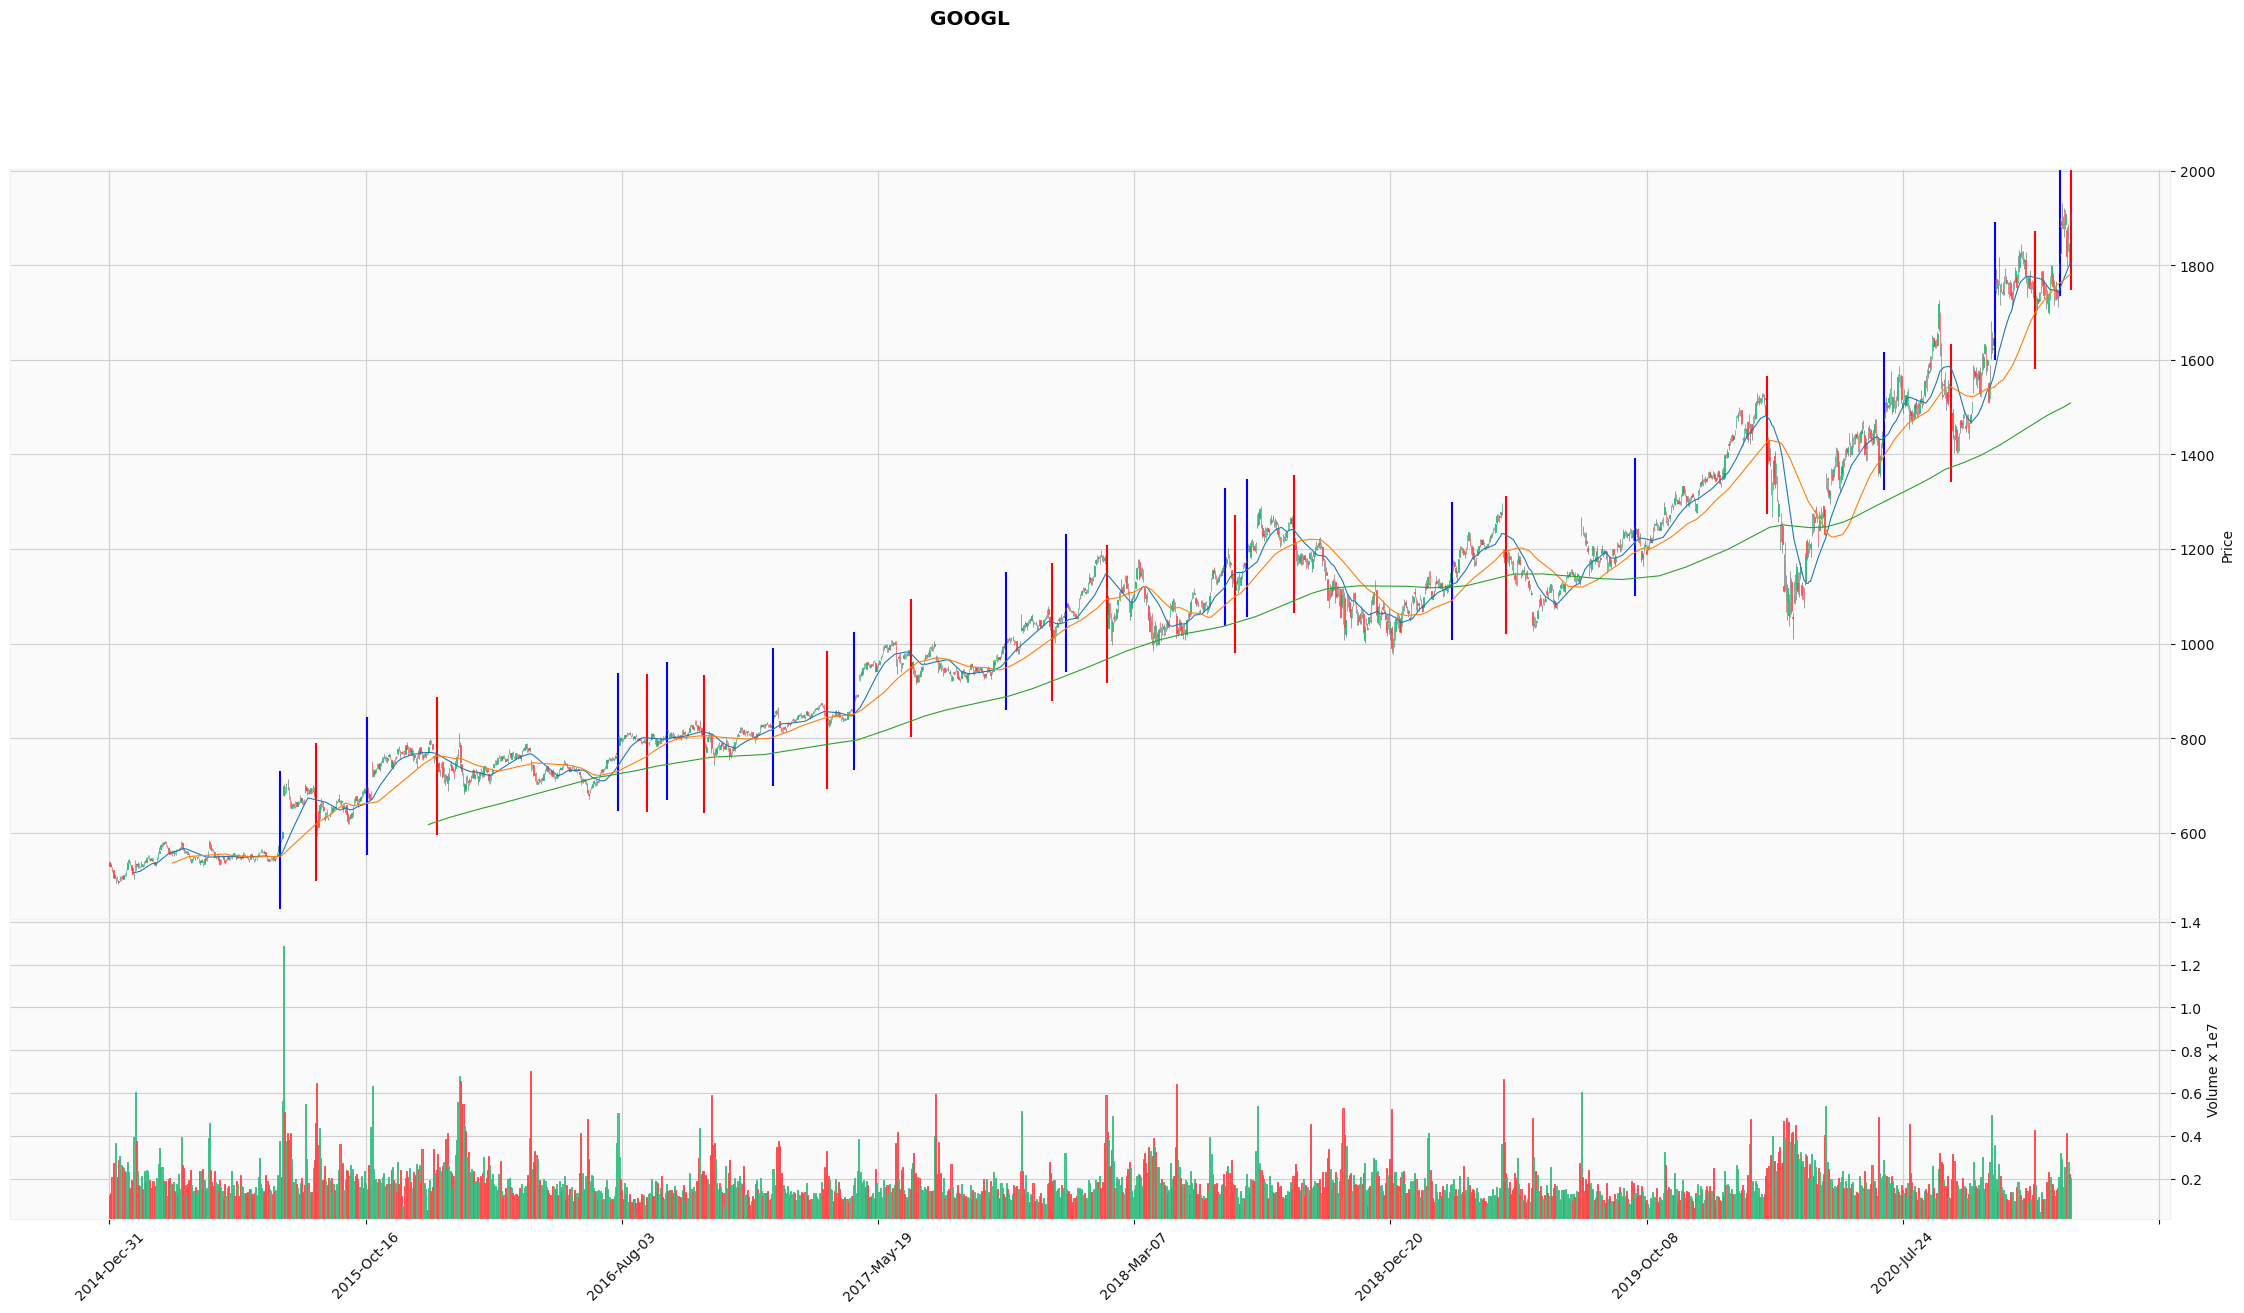

[*********************100%***********************]  1 of 1 completed
GOOG
Date:1531 Last Day Buy at the price 1901.3499755859375


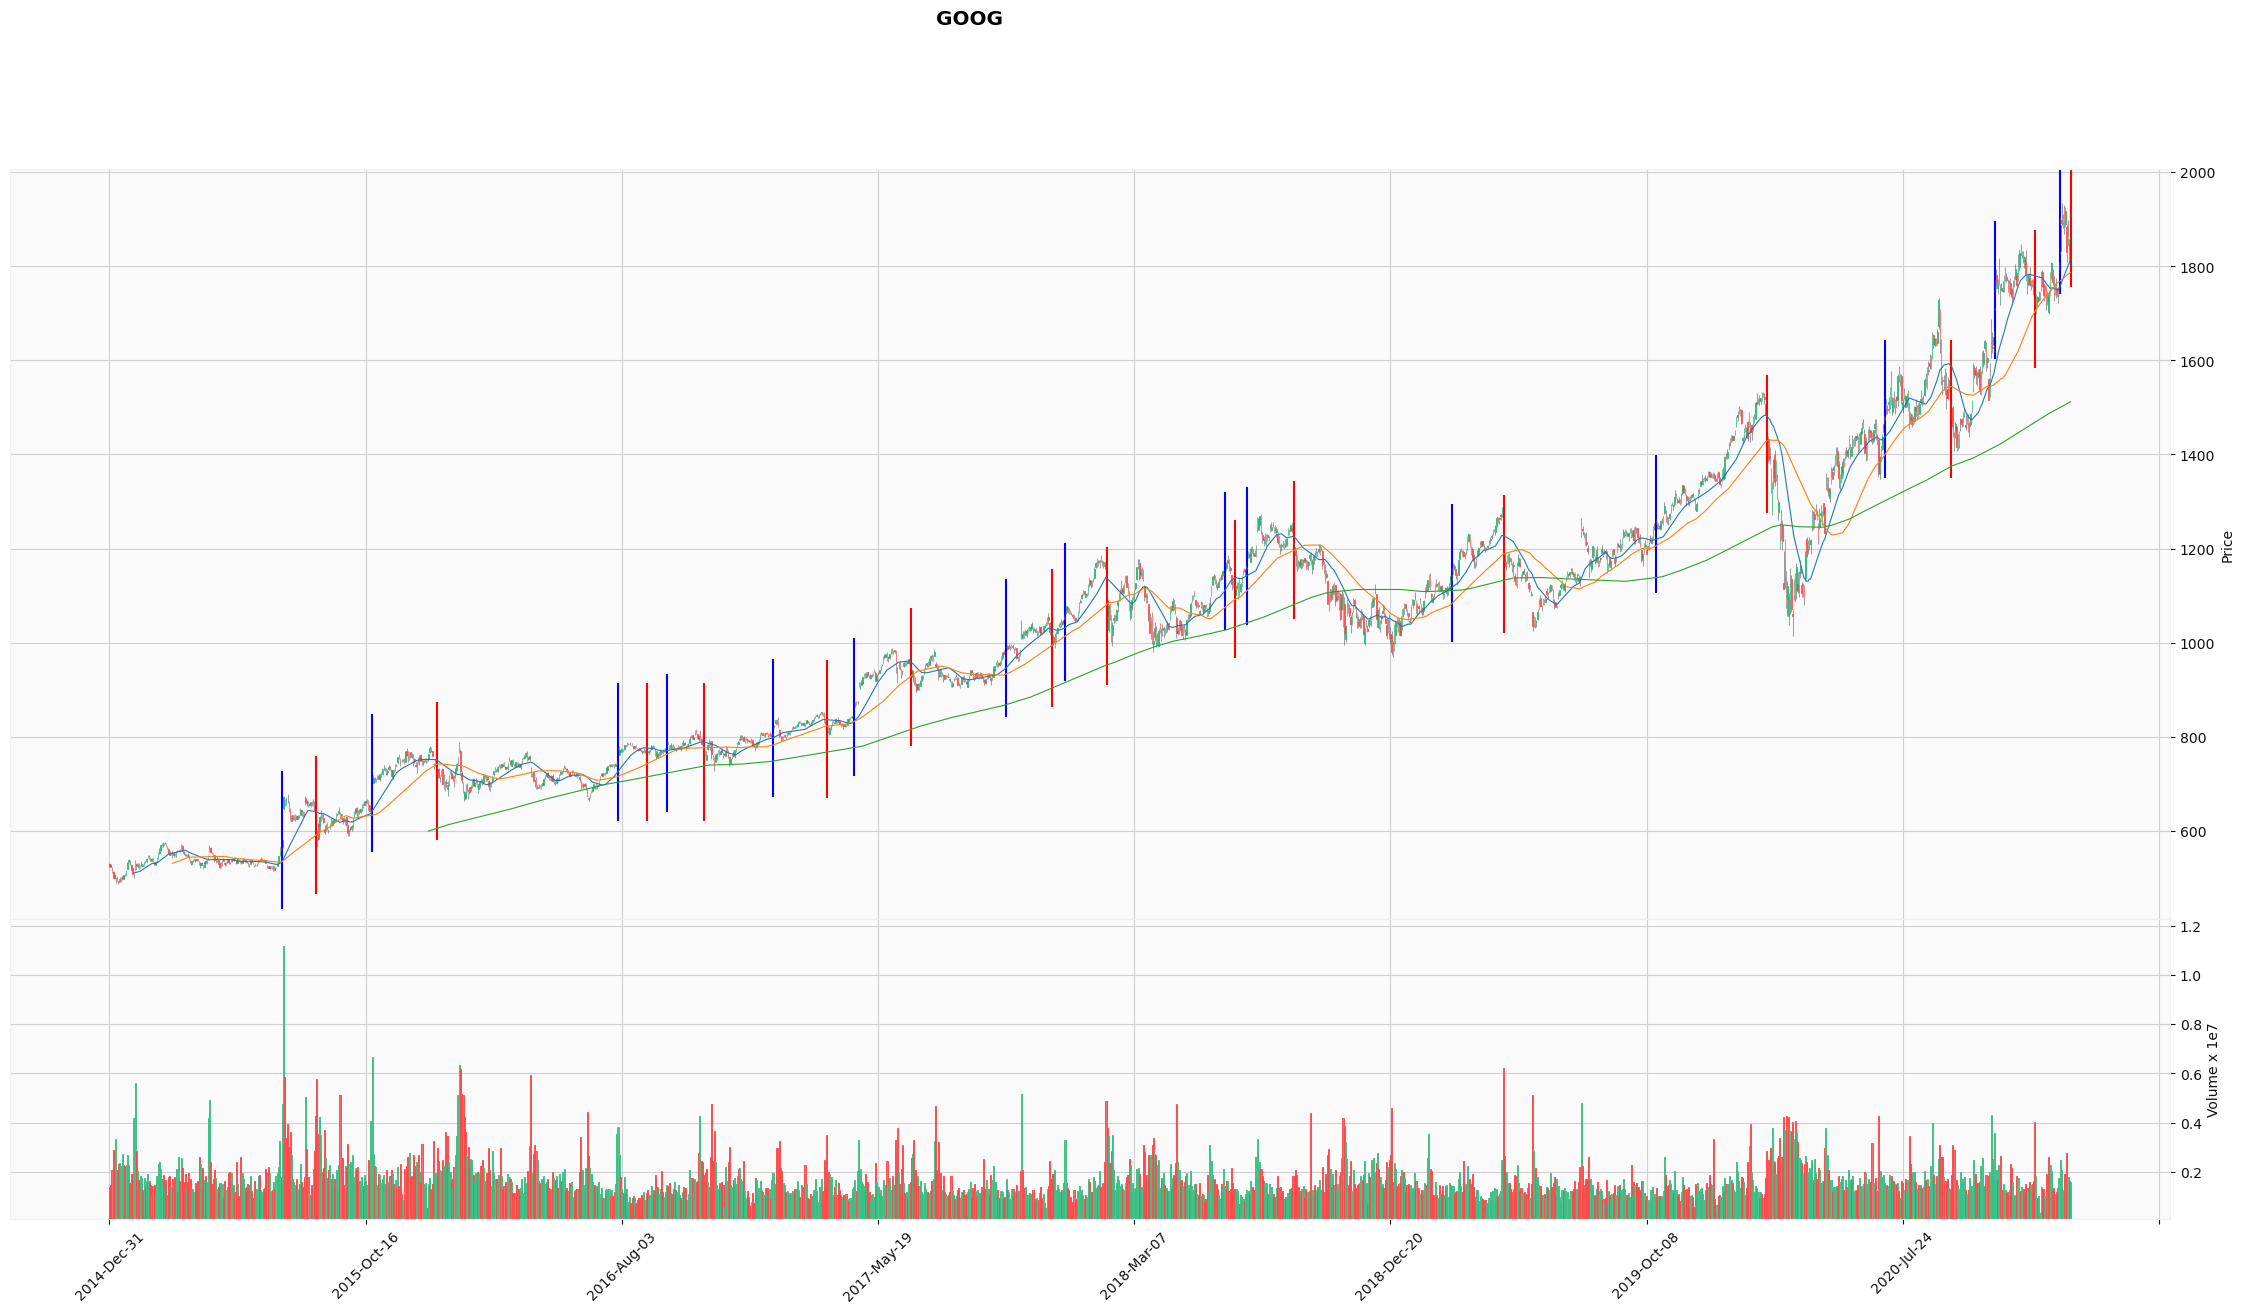

[*********************100%***********************]  1 of 1 completed
AMZN


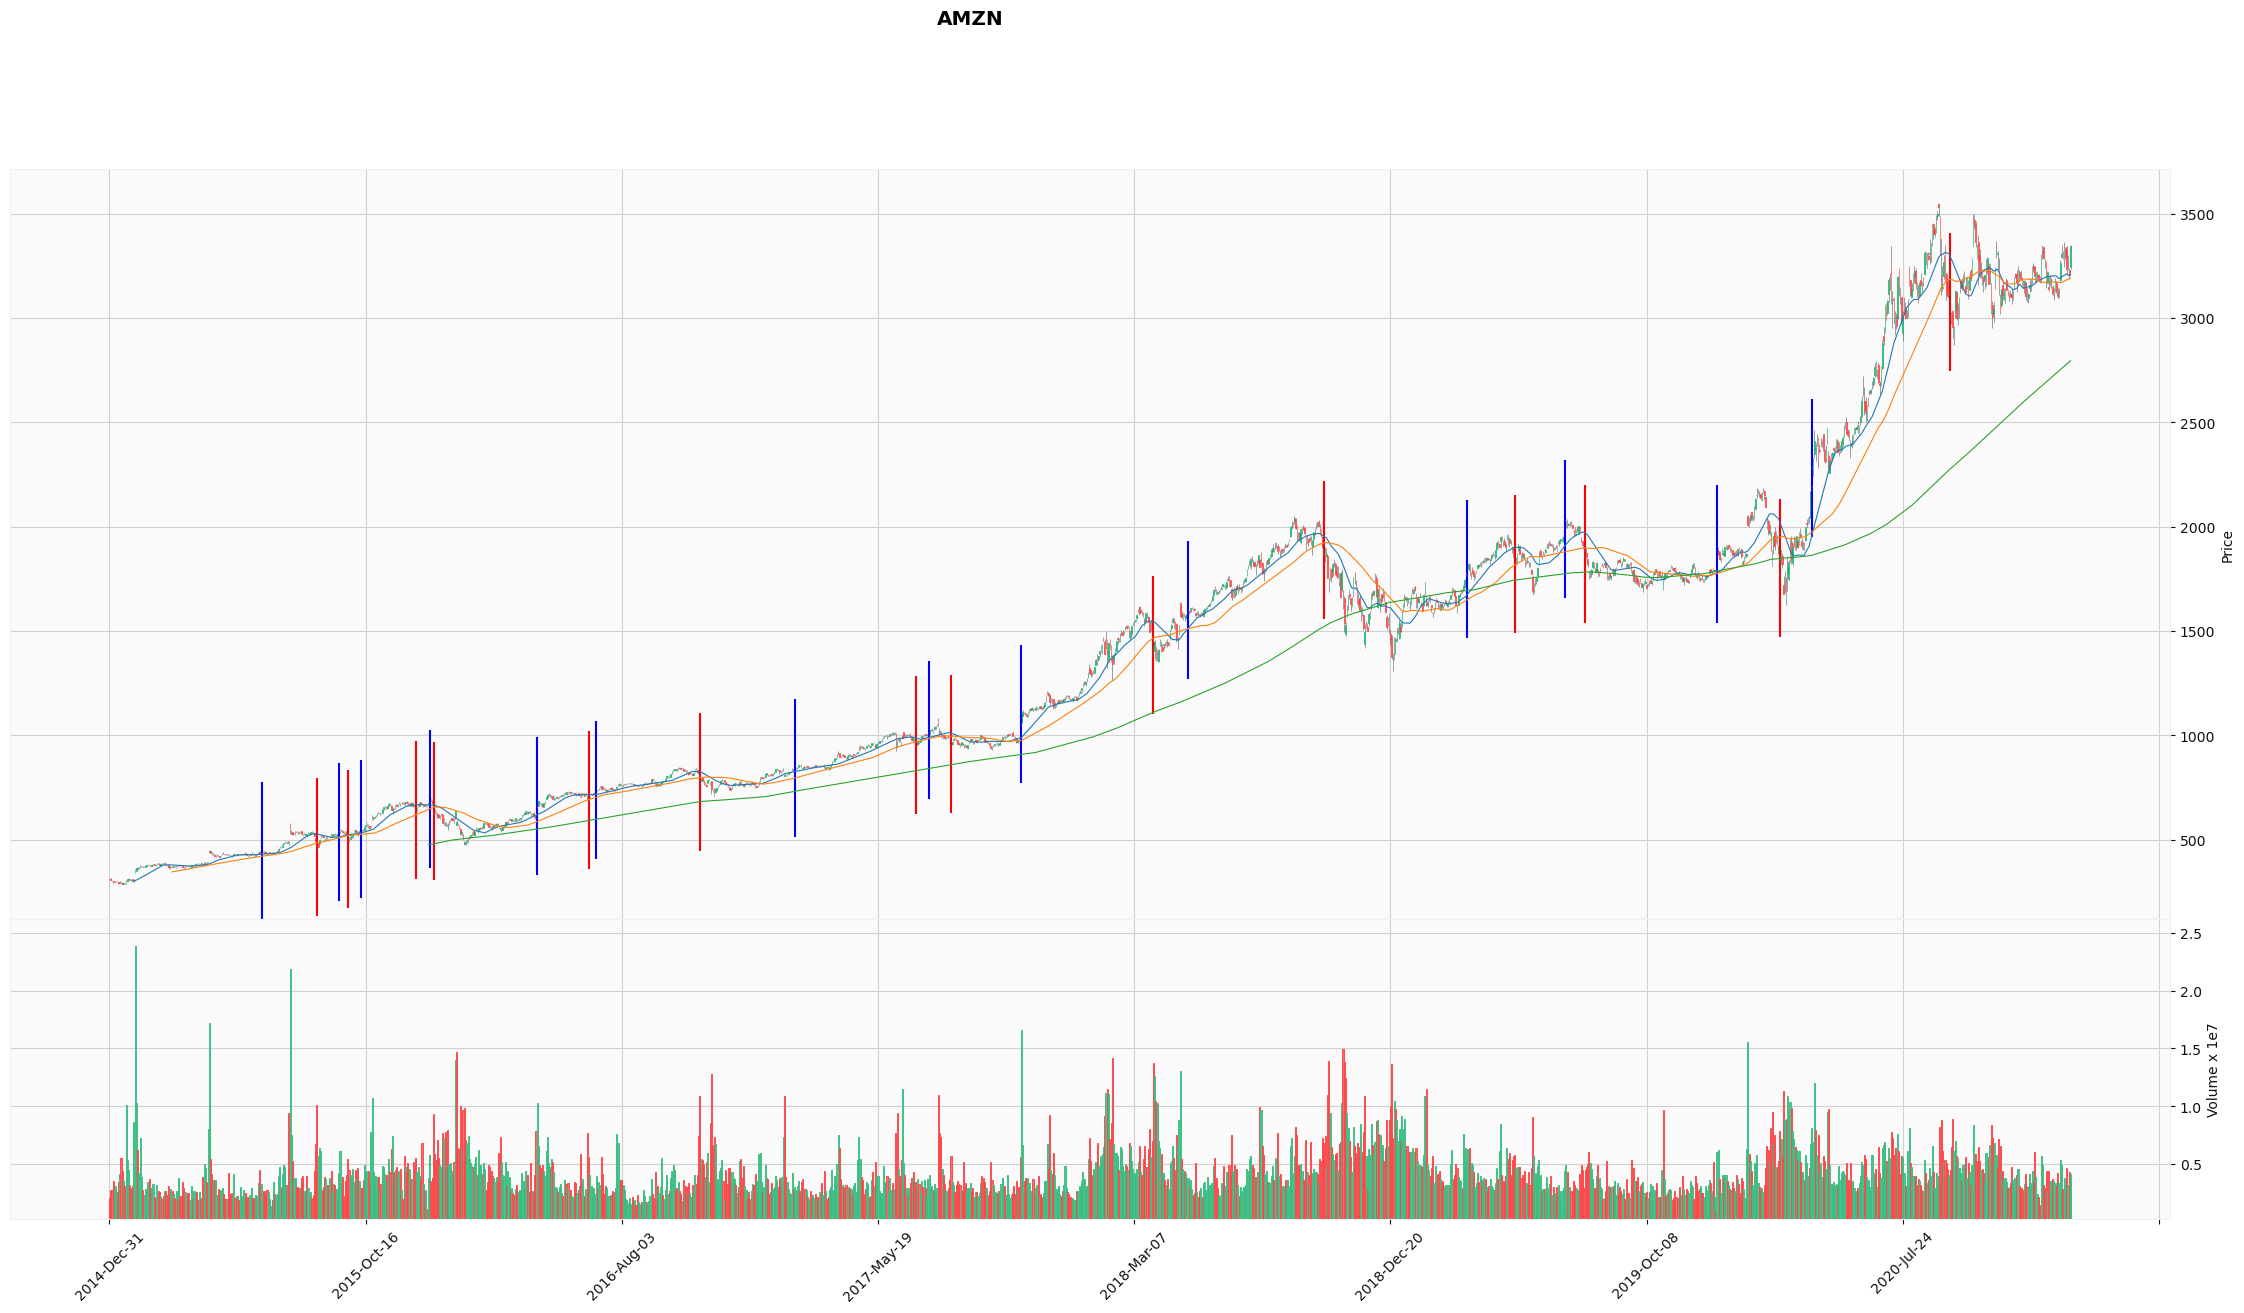

[*********************100%***********************]  1 of 1 completed
AEP


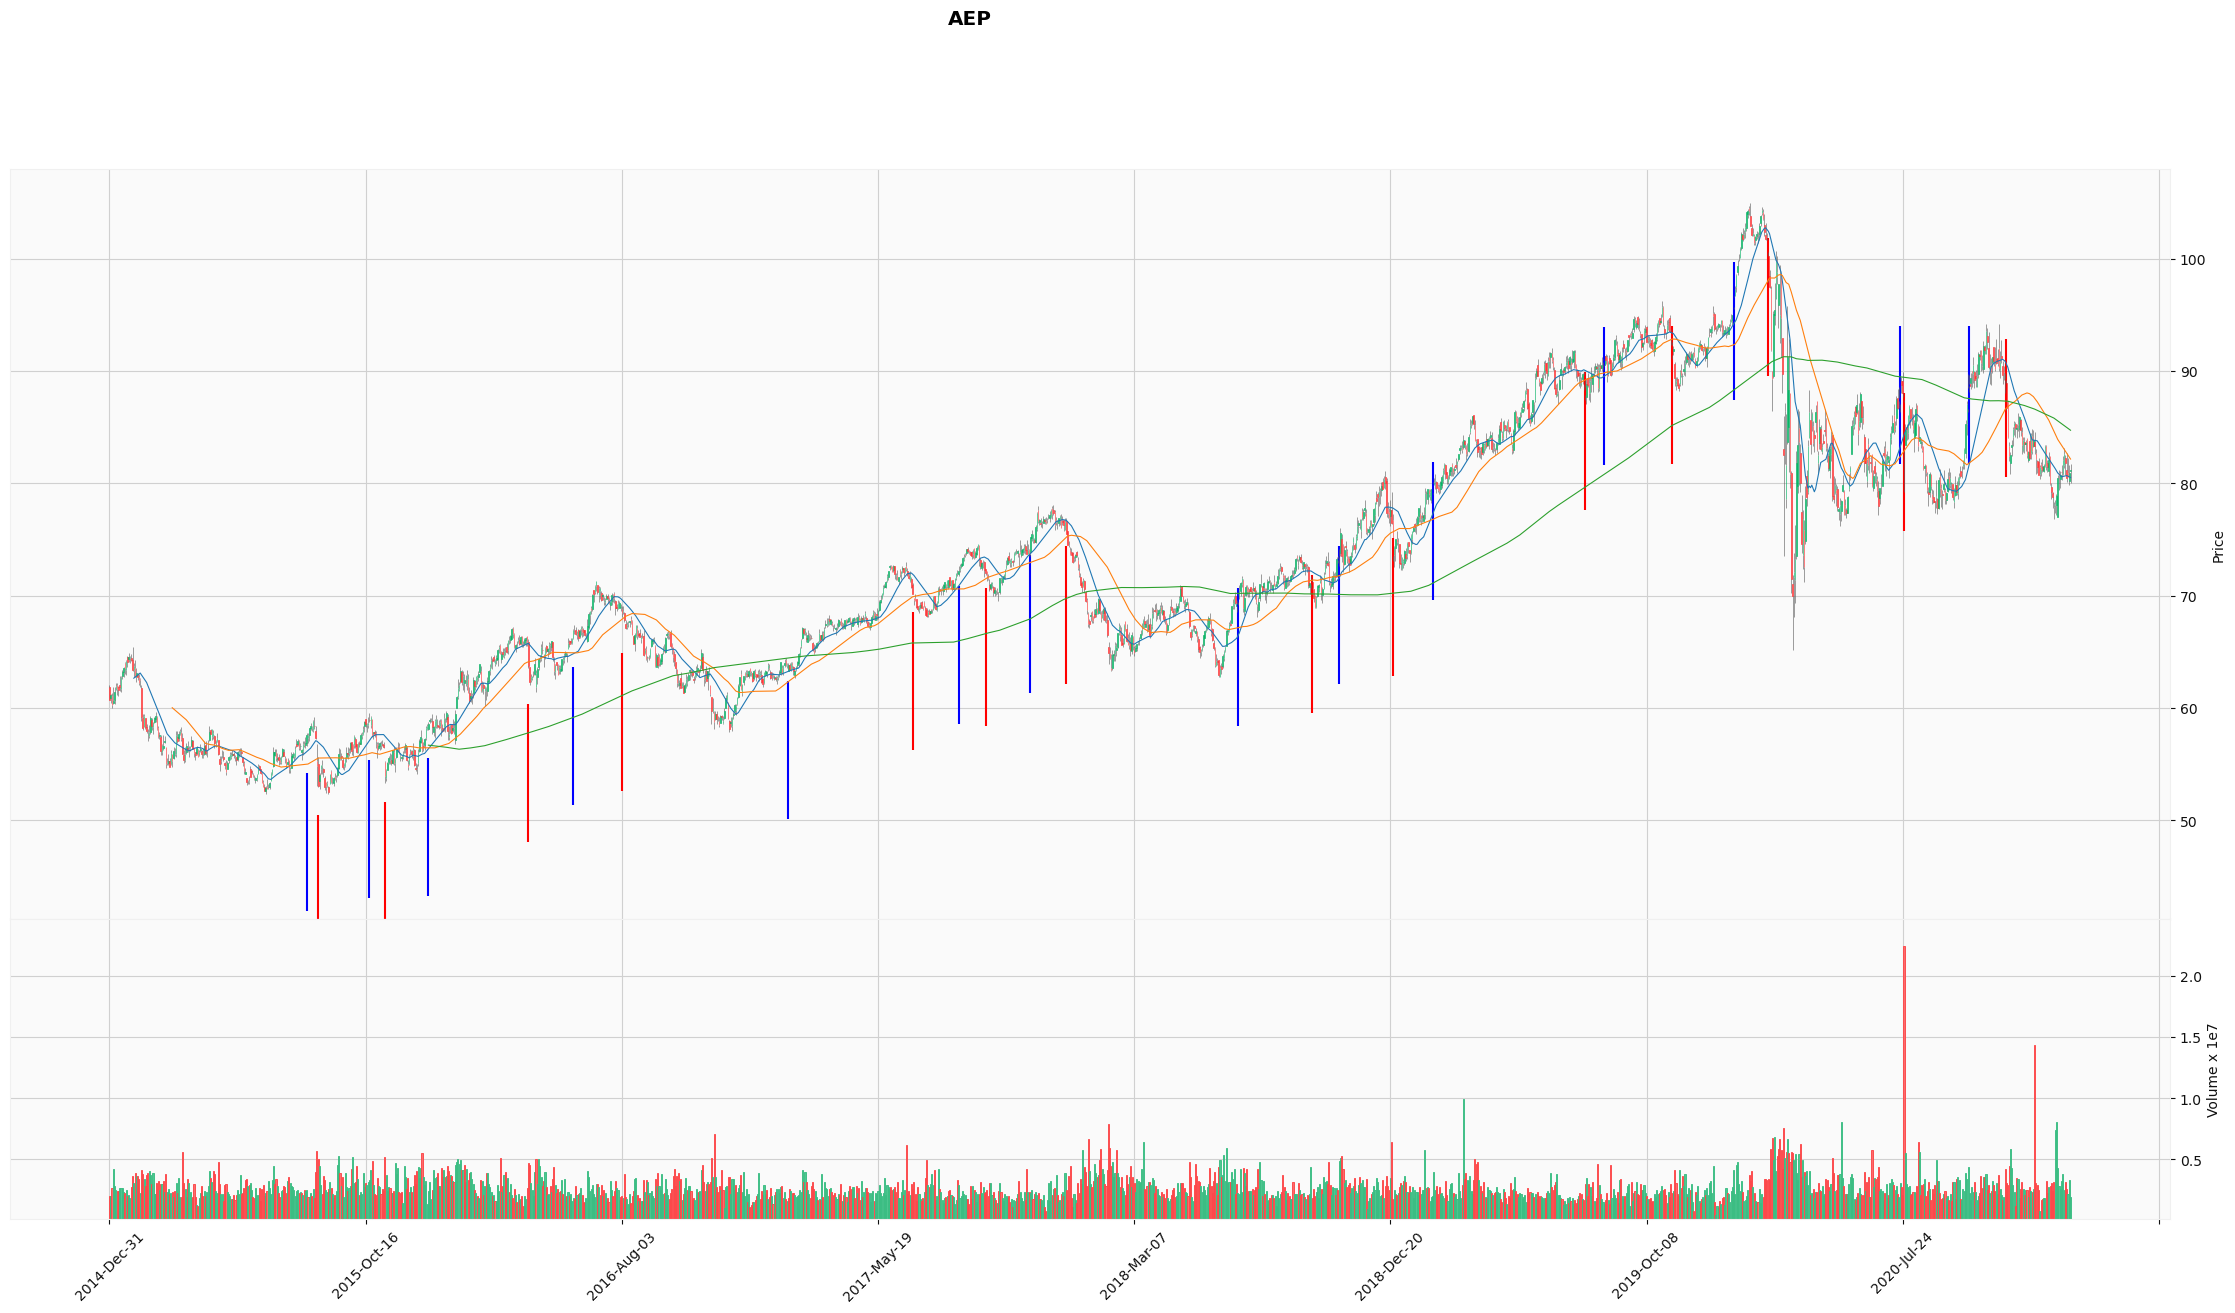

[*********************100%***********************]  1 of 1 completed
AMGN


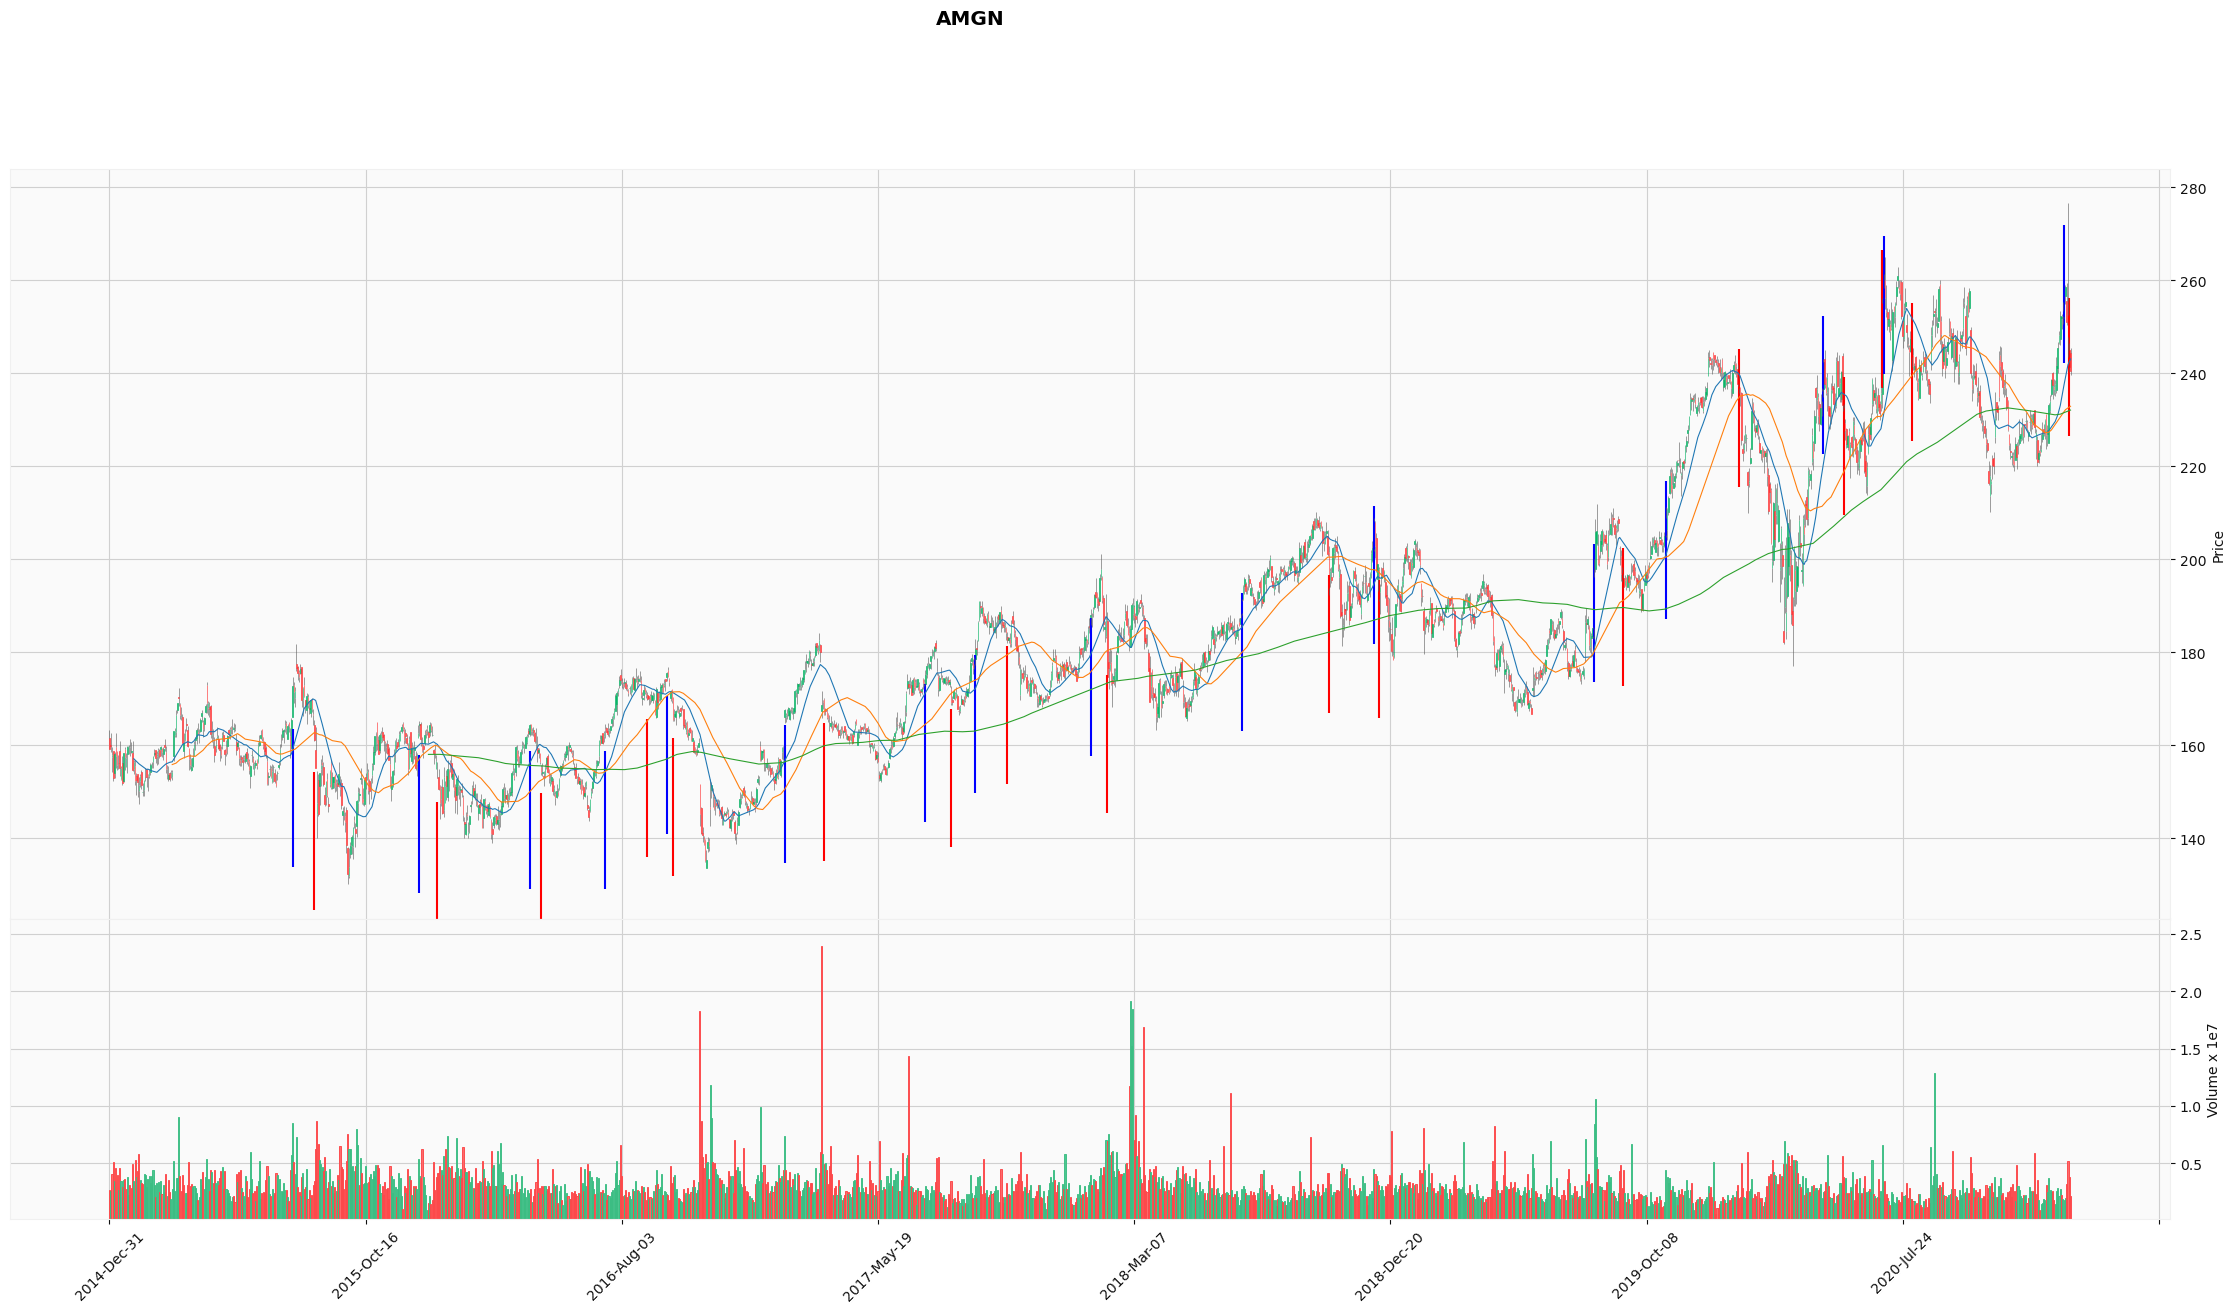

[*********************100%***********************]  1 of 1 completed
ADI
Date:1531 Last Day Buy at the price 151.8800048828125


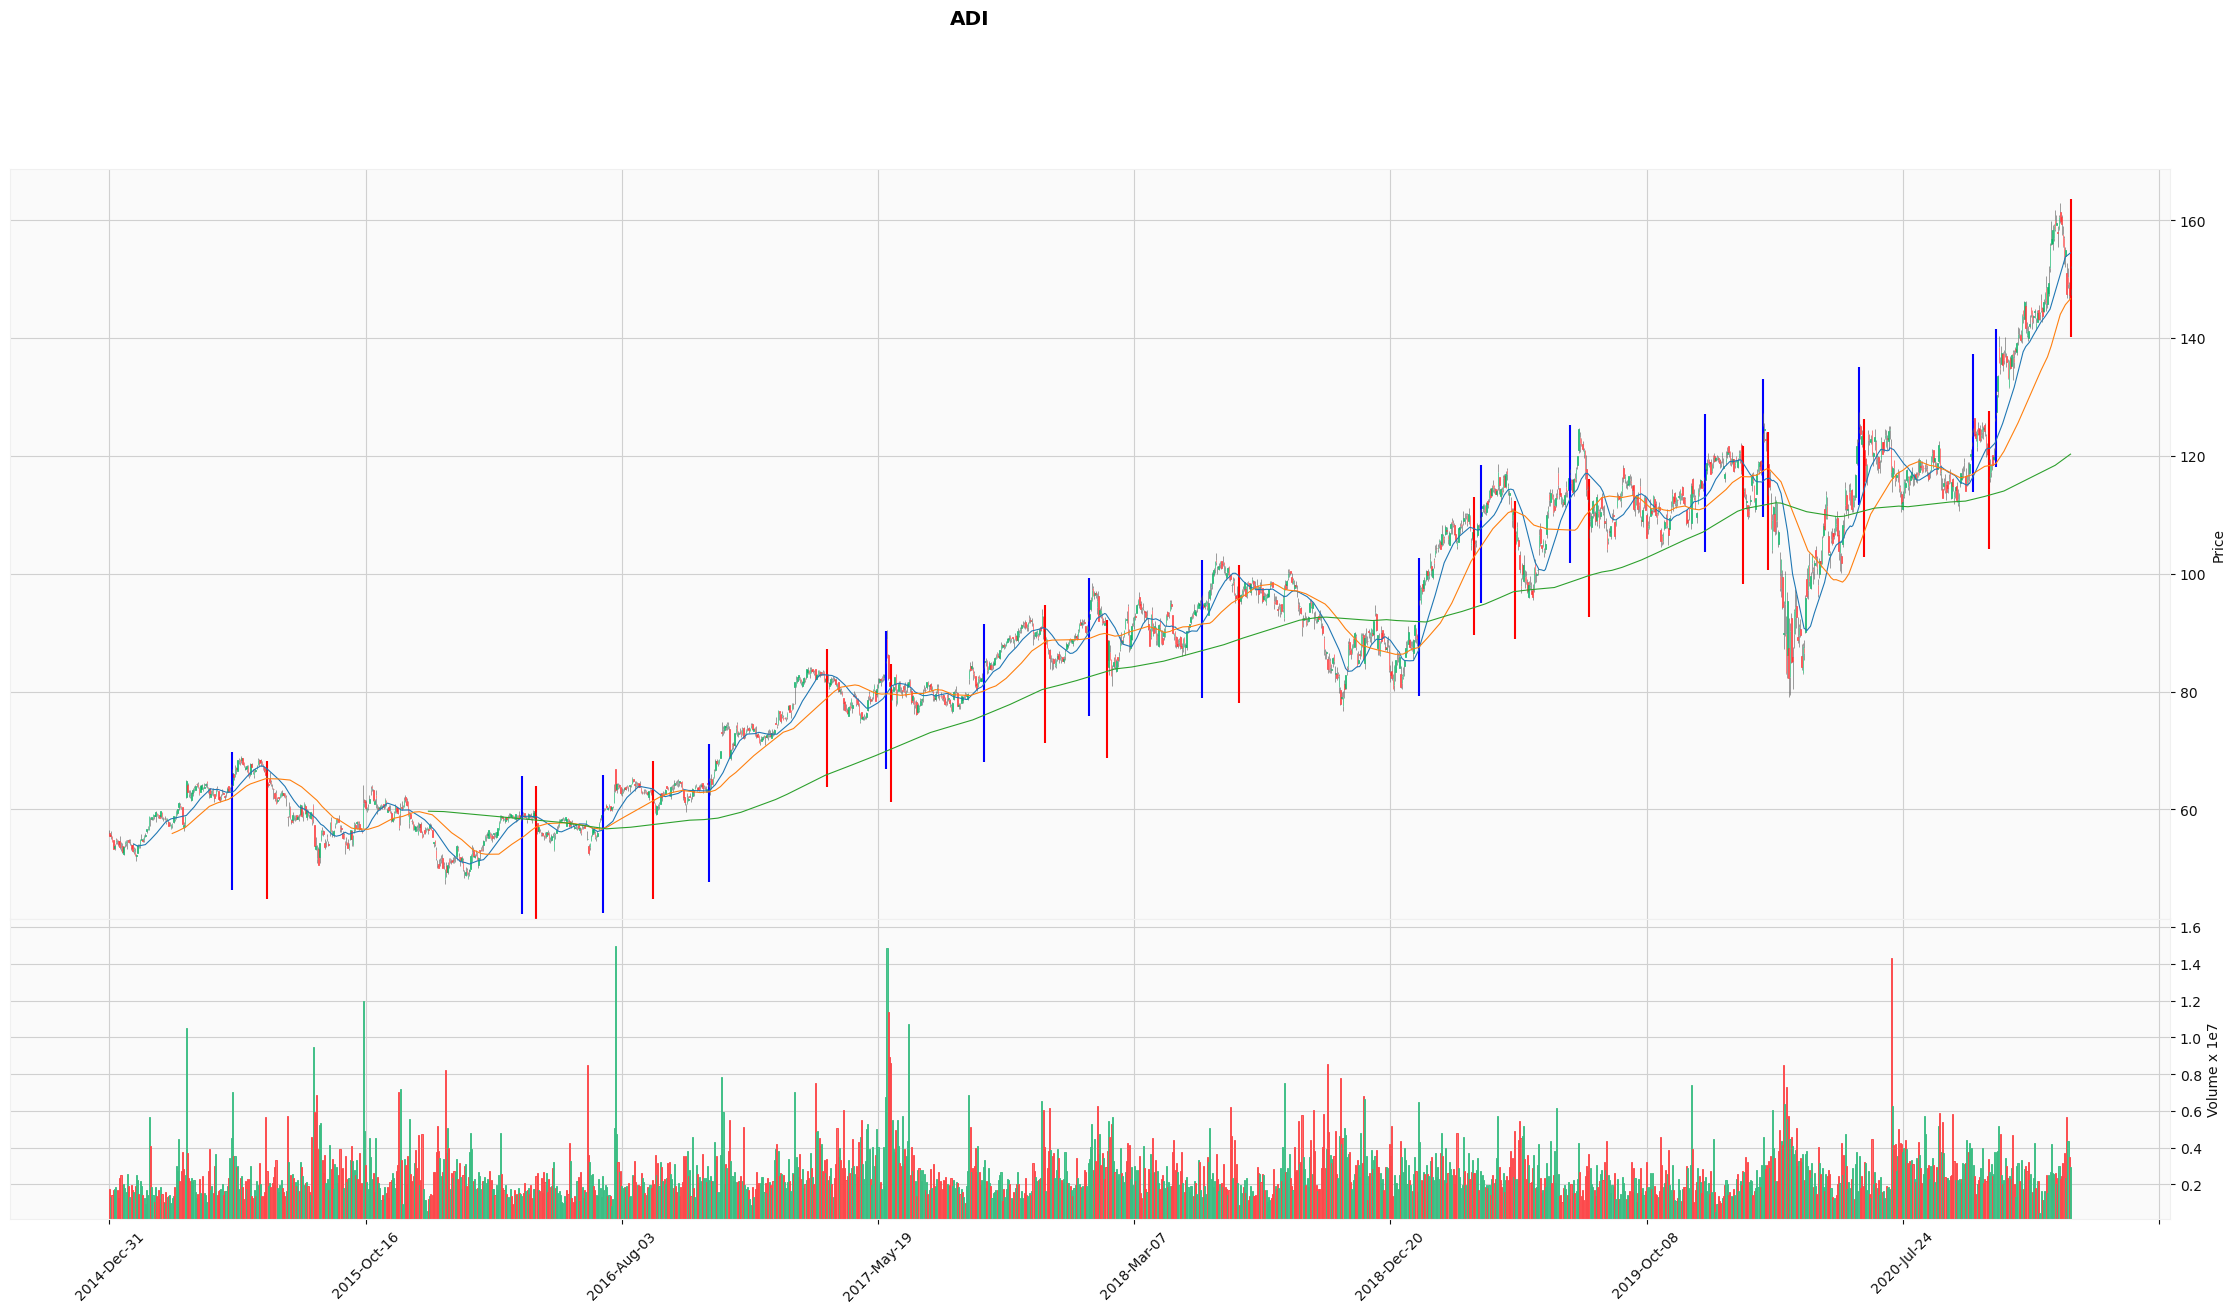

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ANSYS: No data found, symbol may be delisted
ANSYS


TypeError: Expect data.index as DatetimeIndex

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import mplfinance as mpl
import os


#install symbols nasdaq100の銘柄コード

# df = pd.read_csv('./nasdaq100.csv')

# sign = []
# for symbol in df['symbol']:
#     sign.append(symbol)


sign =['ATVI', 'AMD', 'ALXN', 'ALGN', 'GOOGL', 'GOOG', 'AMZN', 'AEP', 'AMGN', 'ADI'
        , 'ANSYS', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'TEAM', 'ADSK', 'ADP', 'BIDU', 'BIIB', 'BKNG'
       ]

totalresult = []

for i in sign:
    stock_code = i 
    start = '2015-01-01'
    end = '2021-02-02'
    df = yf.download(stock_code, start, end, interval='1d') 
    
        
    
    print(i)
    term=81
    # chek the highest price in the past {term} times
    df['Highest'+str(term)] = df.iloc[:, 4].rolling(window=term).max()
    # chek the highest price in the past {term} times
    df['Lowest'+str(term)] = df.iloc[:, 4].rolling(window=term).min()
    
    # chek the highest price in the past {term} times 手仕舞い用
    termN = 23
    df['Lowest'+str(termN)] = df.iloc[:, 4].rolling(window=termN).min()
    
        
    #calucurate sma
     # calculation SMA
    short_sma = 20
    long_sma = 50
    verylong_sma = 250
   

    """
    メインループ
    基本戦略
    turtles strategy only
    過去longTerm間の調整済み終値の最高値をその日の調整済み終値が更新したら購入
    損切り率は5%。
    最終日にまだ保持していた場合捌く
    """
    # 資産、購入したときの資産
    assets = [1]
    buy_asset = 1
    # 買いポジションは０にする
    buy_position = False
   
    # 損切り率と利確の日数
    stopLoss = 0.94
    rikaku_day = 80
    
    #買い日と売り日
    buy_days = []
    sell_days = []



    counter=0
    percentChange = []
    for i in range(1, len(df)):
        Highest = df['Highest'+str(term)][i-1]
        Lowest = df['Lowest'+str(term)][i-1]
        LowestN = df['Lowest'+str(termN)][i-1]
        high_price = df['High'][i]
        low_price = df['Low'][i]
        close = df['Adj Close'][i]
        open_price = df['Open'][i]
        last_close = df['Close'][i-1]
        last_high = df['High'][i-1]
        


        if buy_position == False:
            assets.append(assets[i-1])
        else:
            assets.append(buy_asset*(close / buy_price))

        # avoid NaN data 買いトレンド
        if np.isnan( Highest) == False:
            if close > Highest and buy_position == False :
                buy_position = True
                buy_price = close
                buy_stopLine = close * stopLoss
                buy_asset = assets[i]
                buyday = pd.to_datetime(df.index[i])
                buy_days.append(buyday)
                #print('buy'+str(df.index[i]))

         # 損切り
        if buy_position == True and open_price < buy_stopLine:
            buy_position = False 
            percent = (open_price/buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            #print('損切り'+str(df.index[i]))
            
        elif buy_position == True and close < buy_stopLine:
            buy_position = False 
            percent = (buy_stopLine/buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            
            
        #利確　過去N日間の安値を下回ったら手仕舞い
        if buy_position == True and close < LowestN:
            buy_position = False
            percent = (close/buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            

        #  最終日にまだ持ってたら利確する
        if i == (len(df)-1) and buy_position == True:
            buy_position = False
            percent = (close / buy_price - 1) * 100
            percentChange.append(percent)
            sellday = pd.to_datetime(df.index[i])
            sell_days.append(sellday)
            print('Date:'+str(i),'Last Day Buy at the price {}'.format(close))

        counter += 1


    #print(percentChange)

    # statistic
#     ------------------------------------------
    gains = 0
    losses = 0
    numlosses = 0
    numgains = 0
    total_return = 1


    for i in percentChange:
        if i > 0:
            numgains += 1
            gains += i
        else:
            numlosses += 1
            losses += i
        total_return = total_return * ((i / 100) + 1)
        
        
    total_return = round((total_return - 1)*100, 2)
    if numgains > 0:
        ave_gain = gains / numgains
#         max_return = max(percentChange)
    else:
        ave_gain = 0
        max_return = 'unknown'
    
    if numlosses > 0:
        ave_loss = losses / numlosses
#         max_loss = min(percentChange)
        risk_reward_retio = - ave_gain / ave_loss
    else:
        ave_loss = 0
        max_loss = 'unknown'
        risk_reward_retio = 'inf'
    
    if numgains > 0 or numlosses > 0:
        batting_retio = numgains / (numgains + numlosses)
    else:
        batting_retio = 0
    
    trades = numgains + numlosses
    ave_total = ave_gain * batting_retio + ave_loss * (1 - batting_retio)

    results = [numgains+numlosses, round(total_return,2), round(ave_gain,2), round(ave_loss,2)
               ,batting_retio ,ave_total ]
    
    if not results is None:
         totalresult.append(results)
            
    #買いポイント描写
    buy_signals = []
    sell_signals = []
    for i in df.index:
        if i in buy_days:
            buy_signals.append(df['Adj Close'][i])
        else:
            buy_signals.append(np.nan)
        if i in sell_days:
            sell_signals.append(df['Adj Close'][i])
        else:
            sell_signals.append(np.nan)
    adp = [
        mpl.make_addplot(buy_signals, type='scatter', markersize=10000, marker='|', color="b"),
        mpl.make_addplot(sell_signals, type='scatter', markersize=10000, marker='|', color="r")]
    fig = mpl.plot(df, type='candle',figsize=(30, 15),mav=(short_sma, long_sma, verylong_sma),
               addplot=adp, style='yahoo', volume=True,  title=str(stock_code))



print(totalresult)

columns = ['trades', 'Total return', 'Average Gain', 'Average Loss', '勝率' ,'Average gain and profit']
df = pd.DataFrame(totalresult, columns=columns, index = sign)
df.to_csv('./turtle_result.csv')

print(df)
